# Taller 1 IA2

Fuentes

- https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
- https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-023-02114-6
- https://www.nature.com/articles/s41598-024-77243-7
- https://nebulosa.icesi.edu.co:2138/science/article/pii/S0010482525009060

In [ ]:
# -*- coding: utf-8 -*-
"""
Clasificación de tumores cerebrales (glioma, meningioma, notumor, pituitary)
Modelos disponibles:
  1. CNN personalizada (grayscale)
  2. SVM (HOG + LBP + PCA + SVM)
  3. VGG16 (Transfer Learning)
"""

# =====================================
# BLOQUE 1: Imports y Configuración Global
# =====================================
import os
import sys
import argparse
import numpy as np
import tensorflow as tf
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Evitar warnings innecesarios
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

try:
    import kagglehub
except ImportError:
    kagglehub = None
    print("⚠️ Instala kagglehub: pip install kagglehub")

# Utilidades opcionales (solo si están)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    plt = None
    sns = None

print("Versión TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

def configurar_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for g in gpus:
            try:
                tf.config.experimental.set_memory_growth(g, True)
            except Exception:
                pass
        print("✅ GPU configurada")
    else:
        print("⚠️ Sin GPU, se usará CPU")

configurar_gpu()

@dataclass
class DatasetConfig:
    img_size: Tuple[int, int] = (224, 224)
    batch_size: int = 32
    num_classes: int = 4
    class_names: List[str] = None
    path_root: Optional[str] = None

    def ensure(self):
        if self.class_names is None:
            self.class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
        return self

CFG = DatasetConfig().ensure()

# Descarga dataset (una sola vez)
def descargar_dataset():
    if kagglehub is None:
        raise RuntimeError("kagglehub no disponible. Instala con: pip install kagglehub")
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    print("📁 Dataset en:", path)
    return path

# Cachear la ruta si se desea reutilizar
def obtener_ruta_dataset(force=False):
    if CFG.path_root and not force:
        return CFG.path_root
    CFG.path_root = descargar_dataset()
    return CFG.path_root

# Utilidad: contar imágenes por clase
def contar_imagenes(path_root):
    resumen = {}
    for split in ['Training', 'Testing']:
        split_path = os.path.join(path_root, split)
        split_counts = {}
        for cname in CFG.class_names:
            cdir = os.path.join(split_path, cname)
            count = len(os.listdir(cdir)) if os.path.isdir(cdir) else 0
            split_counts[cname] = count
        resumen[split] = split_counts
    return resumen

Versión TensorFlow: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU configurada


In [ ]:
# =====================================
# BLOQUE 2: Dataset TF (CNN)
# =====================================
def crear_datasets_tf(path_root: str,
                      validation_split=0.2,
                      augment=True):
    img_size = CFG.img_size
    batch = CFG.batch_size

    common_kwargs = dict(
        image_size=img_size,
        batch_size=batch,
        seed=RANDOM_SEED,
        color_mode='grayscale'
    )

    train_dir = os.path.join(path_root, "Training")
    test_dir = os.path.join(path_root, "Testing")

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset="training",
        validation_split=validation_split,
        **common_kwargs
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset="validation",
        validation_split=validation_split,
        **common_kwargs
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        shuffle=False,
        **common_kwargs
    )

    CFG.class_names = train_ds.class_names
    print("Clases:", CFG.class_names)

    def normalize_contrast(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        x = tf.image.adjust_contrast(x, 1.3)
        return tf.clip_by_value(x, 0., 1.), y

    def augment_fn(x, y):
        x = tf.image.random_flip_left_right(x)
        k = tf.random.uniform([], 0, 4, dtype=tf.int32)
        x = tf.image.rot90(x, k)
        x = tf.image.random_brightness(x, 0.1)
        return x, y

    def prepare(ds, do_aug):
        ds = ds.map(normalize_contrast, num_parallel_calls=tf.data.AUTOTUNE)
        if do_aug:
            ds = ds.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.cache().prefetch(tf.data.AUTOTUNE)

    return (prepare(train_ds, augment),
            prepare(val_ds, False),
            prepare(test_ds, False))

def calcular_class_weights(dataset):
    counts = np.zeros(CFG.num_classes, dtype=np.int64)
    for _, labels in dataset:
        for l in labels.numpy():
            counts[l] += 1
    total = counts.sum()
    weights = {i: (total / (CFG.num_classes * c)) for i, c in enumerate(counts) if c > 0}
    print("Distribución clases (train):")
    for i, c in enumerate(counts):
        print(f"  {CFG.class_names[i]}: {c} (peso: {weights[i]:.2f})")
    return weights

In [ ]:
# =====================================
# BLOQUE 3: Modelo CNN Simple
# =====================================
from tensorflow.keras import layers, models, callbacks as cb

def build_cnn(input_shape=(224, 224, 1), num_classes=4, dropout=0.1):
    model = models.Sequential(name="SimpleCNN")
    filters = [8, 16, 32, 64]
    for i, f in enumerate(filters):
        if i == 0:
            model.add(layers.Input(shape=input_shape))
        model.add(layers.Conv2D(f, 3, padding='same', activation='relu'))
        model.add(layers.Conv2D(f, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(dropout))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def entrenar_cnn(train_ds, val_ds, class_weights,
                 epochs=60,
                 lr=1e-3,
                 weights_path="best_cnn.weights.h5"):
    model = build_cnn(input_shape=CFG.img_size + (1,), num_classes=CFG.num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    cbs = [
        cb.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        cb.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
        cb.ModelCheckpoint(weights_path, monitor='val_accuracy',
                           save_best_only=True, save_weights_only=True, verbose=1)
    ]
    print("Entrenando CNN...")
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        class_weight=class_weights,
                        verbose=1,
                        callbacks=cbs)
    model.load_weights(weights_path)
    return model, history

def evaluar_modelo(model, test_ds):
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")
    return acc, loss

def matriz_confusion_y_reporte(model, test_ds):
    try:
        from sklearn.metrics import confusion_matrix, classification_report
    except ImportError:
        print("Instala scikit-learn para métricas avanzadas.")
        return
    y_true, y_pred = [], []
    for x, y in test_ds:
        probs = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(probs, axis=1))
        y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print("\nReporte de Clasificación:\n", classification_report(y_true, y_pred,
                                                                target_names=CFG.class_names))
    if plt and sns:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=CFG.class_names, yticklabels=CFG.class_names)
        plt.title("Matriz de Confusión - CNN")
        plt.ylabel("Real")
        plt.xlabel("Predicción")
        plt.tight_layout()
        plt.show()

def visualizar_predicciones(model, test_ds, n=8):
    if not plt:
        return
    for images, labels in test_ds.take(1):
        probs = model.predict(images, verbose=0)
        plt.figure(figsize=(14, 6))
        for i in range(min(n, len(images))):
            ax = plt.subplot(2, n//2, i+1)
            ax.imshow(images[i].numpy().squeeze(), cmap='gray')
            t = CFG.class_names[labels[i]]
            p = CFG.class_names[np.argmax(probs[i])]
            color = 'green' if t == p else 'red'
            ax.set_title(f"T:{t}\nP:{p}", color=color, fontsize=9)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
# =====================================
# BLOQUE 4: Evaluador interactivo CNN (bajo demanda)
# =====================================
def preparar_evaluador_imagenes(model, path_root):
    from PIL import Image
    test_dir = os.path.join(path_root, "Testing")
    imgs, labels, fnames = [], [], []
    for cls_idx, cname in enumerate(CFG.class_names):
        cdir = os.path.join(test_dir, cname)
        if not os.path.isdir(cdir):
            continue
        for f in os.listdir(cdir):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                p = os.path.join(cdir, f)
                arr = Image.open(p).convert('L').resize(CFG.img_size)
                arr = np.array(arr, dtype=np.float32) / 255.0
                arr = np.expand_dims(arr, -1)
                imgs.append(arr)
                labels.append(cls_idx)
                fnames.append(f"{cname}/{f}")

    imgs = np.array(imgs)
    labels = np.array(labels)

    def evaluar(idx: int):
        if idx >= len(imgs):
            print("Índice fuera de rango.")
            return
        x = imgs[idx]
        prob = model.predict(np.expand_dims(x, 0), verbose=0)[0]
        pred = np.argmax(prob)
        real = labels[idx]
        ok = pred == real
        print(f"Imagen #{idx} -> {fnames[idx]}")
        print(f"Real: {CFG.class_names[real]} | Pred: {CFG.class_names[pred]} (conf {prob[pred]:.3f}) {'✅' if ok else '❌'}")
        if plt:
            plt.figure(figsize=(8, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(x.squeeze(), cmap='gray')
            plt.title("Imagen")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.bar(CFG.class_names, prob)
            plt.xticks(rotation=45)
            plt.title("Probabilidades")
            plt.tight_layout()
            plt.show()

    def buscar(clase: str):
        matches = [i for i, n in enumerate(fnames) if clase.lower() in n.lower()]
        print(f"{len(matches)} coincidencias de '{clase}'. Ejemplos:", matches[:10])
        return matches

    return evaluar, buscar, len(imgs)

In [ ]:
# =====================================
# BLOQUE 5: SVM (HOG + LBP + PCA + RandomizedSearch)
# =====================================
def svm_pipeline(path_root,
                 max_per_class=300,
                 pca_components=50,
                 random_search_iter=20):
    print("=== SVM Pipeline ===")
    try:
        import cv2
        from skimage.feature import hog, local_binary_pattern
        from sklearn.preprocessing import StandardScaler, LabelEncoder
        from sklearn.decomposition import PCA
        from sklearn.model_selection import train_test_split, RandomizedSearchCV
        from sklearn.svm import SVC
        from sklearn.metrics import classification_report, accuracy_score
        from scipy.stats import loguniform
        from tqdm import tqdm
    except ImportError:
        print("Instala dependencias SVM: opencv-python scikit-image scikit-learn tqdm scipy")
        return

    def preprocess(image_path, target=(32, 32)):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        img = cv2.resize(img, target, interpolation=cv2.INTER_AREA)
        return img.astype(np.float32) / 255.0

    def extract_feats(img):
        lbp = local_binary_pattern(img, 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10))
        lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-7)
        hog_feat = hog(img, orientations=6, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True)
        return np.concatenate([lbp_hist, hog_feat])

    feat_list, label_list = [], []
    for split in ['Training', 'Testing']:
        for cname in CFG.class_names:
            cdir = os.path.join(path_root, split, cname)
            if not os.path.isdir(cdir):
                continue
            files = [f for f in os.listdir(cdir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:max_per_class]
            print(f"{split}/{cname}: {len(files)} imágenes")
            for f in tqdm(files, desc=f"{cname}", leave=False):
                p = os.path.join(cdir, f)
                img = preprocess(p)
                if img is None:
                    continue
                feat_list.append(extract_feats(img))
                label_list.append(cname)

    X = np.array(feat_list)
    y = np.array(label_list)
    print("Características:", X.shape)

    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=min(pca_components, Xs.shape[1]))
    Xp = pca.fit_transform(Xs)
    print("Dimensión reducida:", Xp.shape[1])

    X_train, X_test, y_train, y_test = train_test_split(
        Xp, y_enc, test_size=0.2, random_state=RANDOM_SEED, stratify=y_enc
    )

    param_dist = {
        "C": loguniform(1e-2, 1e2),
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto'] + list(loguniform(1e-3, 1).rvs(3, random_state=RANDOM_SEED))
    }

    search = RandomizedSearchCV(
        SVC(probability=True, random_state=RANDOM_SEED),
        param_distributions=param_dist,
        n_iter=random_search_iter,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=RANDOM_SEED,
        verbose=1
    )
    search.fit(X_train, y_train)
    print("Mejores params:", search.best_params_)

    best = search.best_estimator_
    pred = best.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"Accuracy SVM: {acc:.4f}")
    print("\nReporte:\n", classification_report(y_test, pred, target_names=le.classes_))
    return {
        "model": best,
        "scaler": scaler,
        "pca": pca,
        "label_encoder": le,
        "accuracy": acc
    }

In [ ]:
# =====================================
# BLOQUE 6: VGG16 Transfer Learning
# =====================================
def vgg16_pipeline(path_root,
                   batch_size=64,
                   epochs=15,
                   lr=1e-3,
                   dropout=0.3,
                   weights_file='best_vgg16.keras',
                   fine_tune=False,
                   fine_tune_layers=4):
    print("=== VGG16 Transfer Learning ===")
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

    train_dir = os.path.join(path_root, "Training")
    test_dir = os.path.join(path_root, "Testing")

    train_aug = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        validation_split=0.2
    )
    test_aug = ImageDataGenerator(rescale=1./255)

    train_gen = train_aug.flow_from_directory(
        train_dir,
        target_size=CFG.img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=RANDOM_SEED
    )
    val_gen = train_aug.flow_from_directory(
        train_dir,
        target_size=CFG.img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=RANDOM_SEED,
        shuffle=False
    )
    test_gen = test_aug.flow_from_directory(
        test_dir,
        target_size=CFG.img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    CFG.class_names = list(train_gen.class_indices.keys())

    # Class weights
    counts = {}
    for cname, idx in train_gen.class_indices.items():
        cdir = os.path.join(train_dir, cname)
        counts[idx] = len(os.listdir(cdir))
    total = sum(counts.values())
    class_weights = {i: total / (len(counts) * c) for i, c in counts.items()}
    print("Class weights:", class_weights)

    base = VGG16(weights='imagenet', include_top=False,
                 input_shape=CFG.img_size + (3,))
    for layer in base.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(dropout)(x)
    out = Dense(CFG.num_classes, activation='softmax')(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    cbs = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1),
        ModelCheckpoint(weights_file, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    steps_train = max(1, train_gen.samples // batch_size)
    steps_val = max(1, val_gen.samples // batch_size)

    history = model.fit(
        train_gen,
        steps_per_epoch=steps_train,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=steps_val,
        class_weight=class_weights,
        callbacks=cbs,
        verbose=1
    )

    # Fine-tuning opcional
    if fine_tune:
        print("Iniciando fine-tuning...")
        for layer in base.layers[-fine_tune_layers:]:
            layer.trainable = True
        model.compile(optimizer=Adam(lr * 0.1),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(
            train_gen,
            steps_per_epoch=steps_train,
            epochs=5,
            validation_data=val_gen,
            validation_steps=steps_val,
            class_weight=class_weights,
            verbose=1
        )

    model.load_weights(weights_file) if os.path.exists(weights_file) else None

    # Evaluación
    test_steps = max(1, test_gen.samples // batch_size)
    test_loss, test_acc = model.evaluate(test_gen, steps=test_steps, verbose=0)
    print(f"VGG16 Test Accuracy: {test_acc:.4f}")

    # Reporte
    try:
        from sklearn.metrics import classification_report, confusion_matrix
        preds = model.predict(test_gen, steps=test_steps, verbose=0)
        y_pred = np.argmax(preds, axis=1)
        y_true = test_gen.classes[:len(y_pred)]
        print("\nReporte:\n", classification_report(y_true, y_pred,
                                                    target_names=CFG.class_names))
        if plt and sns:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=CFG.class_names, yticklabels=CFG.class_names)
            plt.title("Matriz de Confusión - VGG16")
            plt.tight_layout()
            plt.show()
    except ImportError:
        pass

    return model, history, test_acc

📁 Dataset en: /kaggle/input/brain-tumor-mri-dataset
Resumen dataset:
  Training: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
  Testing: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}

--- Running CNN Model ---
Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Clases: ['glioma', 'meningioma', 'notumor', 'pituitary']
Distribución clases (train):
  glioma: 1077 (peso: 1.06)
  meningioma: 1090 (peso: 1.05)
  notumor: 1247 (peso: 0.92)
  pituitary: 1156 (peso: 0.99)
Entrenando CNN...
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5527 - loss: 1.9203
Epoch 1: val_accuracy improved from -inf to 0.39142, saving model to best_cnn.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.5531 - loss: 1.9160 - val_accuracy: 0.3914 - val_loss: 1.3433 - learning_rate: 0.0010
Epoch 2/

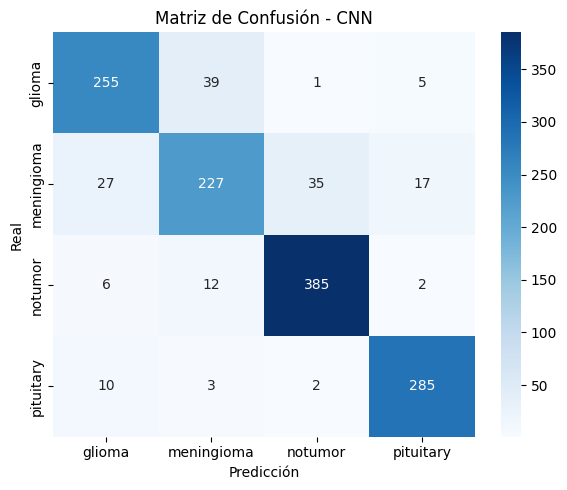

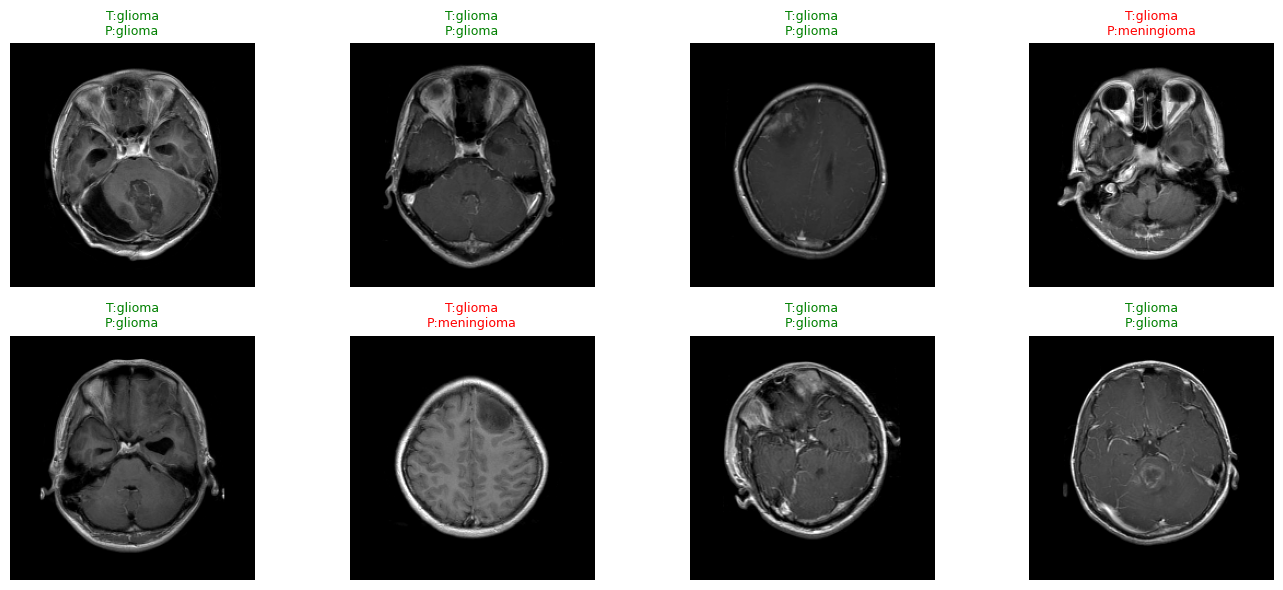


Uso interactivo (notebook): evaluar_fn(0) | buscar_fn('glioma') | total imágenes=1311

--- Running SVM Model ---
=== SVM Pipeline ===
Training/glioma: 300 imágenes


glioma:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Training/meningioma: 300 imágenes


Training/notumor: 300 imágenes


Training/pituitary: 300 imágenes


Testing/glioma: 300 imágenes


Testing/meningioma: 300 imágenes


Testing/notumor: 300 imágenes


Testing/pituitary: 300 imágenes


Características: (2400, 226)
Dimensión reducida: 50
Fitting 3 folds for each of 20 candidates, totalling 60 fits


Mejores params: {'C': np.float64(2.754143921332031), 'gamma': np.float64(0.013292918943162165), 'kernel': 'rbf'}
Accuracy SVM: 0.8625

Reporte:
               precision    recall  f1-score   support

      glioma       0.84      0.76      0.80       120
  meningioma       0.75      0.78      0.76       120
     notumor       0.96      0.95      0.95       120
   pituitary       0.91      0.96      0.93       120

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480


--- Running VGG16 Model ---
=== VGG16 Transfer Learning ===
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.3075 - loss: 1.4228
Epoch 1: val_accuracy improved from -inf to 0.54504, saving model to best_vgg16.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.3084 - loss: 1.4216 - val_accuracy: 0.5450 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 2/12
 1/71 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.4531 - loss: 1.2104

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.54504 to 0.56710, saving model to best_vgg16.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.4531 - loss: 1.2104 - val_accuracy: 0.5671 - val_loss: 1.2218 - learning_rate: 0.0010
Epoch 3/12
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.5462 - loss: 1.1548
Epoch 3: val_accuracy improved from 0.56710 to 0.62684, saving model to best_vgg16.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5468 - loss: 1.1542 - val_accuracy: 0.6268 - val_loss: 1.1147 - learning_rate: 0.0010
Epoch 4/12
 1/71 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.5625 - loss: 1.1173
Epoch 4: val_accuracy improved from 0.62684 to 0.64062, saving model to best_vgg16.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.5625 - loss: 1.1173 - val_accuracy: 0.6406 - val_loss: 1.1126 - learning_rate: 0.0010
Epoch 5/12
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6839 - loss: 0.9840
Epoch 5: val_accuracy improved from 0.64062 to 0.

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


VGG16 Test Accuracy: 0.7391

Reporte:
               precision    recall  f1-score   support

      glioma       0.77      0.68      0.72       300
  meningioma       0.60      0.51      0.55       306
     notumor       0.83      0.87      0.85       405
   pituitary       0.71      0.87      0.78       269

    accuracy                           0.74      1280
   macro avg       0.73      0.73      0.73      1280
weighted avg       0.73      0.74      0.73      1280



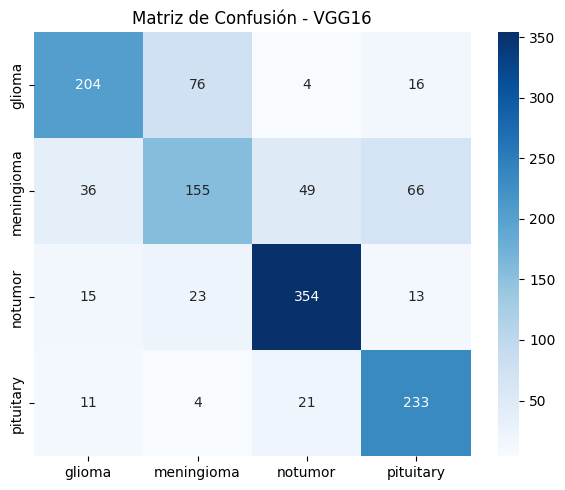

In [ ]:
# =====================================
# BLOQUE 7: CLI / Main
# =====================================
# Remove argparse and main execution block for notebook compatibility

def run_models(model_list: List[str],
               epochs_cnn: int = 40,
               epochs_vgg: int = 12,
               fine_tune_vgg: bool = False,
               use_cached_dataset: bool = False):

    modelos = [m.strip().lower() for m in model_list]
    path_root = obtener_ruta_dataset(force=not use_cached_dataset)

    # Resumen dataset
    print("Resumen dataset:")
    for split, counts in contar_imagenes(path_root).items():
        print(f"  {split}: {counts}")

    if 'cnn' in modelos:
        print("\n--- Running CNN Model ---")
        train_ds, val_ds, test_ds = crear_datasets_tf(path_root)
        cw = calcular_class_weights(train_ds)
        cnn_model, hist = entrenar_cnn(train_ds, val_ds, cw, epochs=epochs_cnn)
        evaluar_modelo(cnn_model, test_ds)
        matriz_confusion_y_reporte(cnn_model, test_ds)
        visualizar_predicciones(cnn_model, test_ds, n=8)
        # Preparar evaluador interactivo
        evaluar_fn, buscar_fn, total = preparar_evaluador_imagenes(cnn_model, path_root)
        print(f"\nUso interactivo (notebook): evaluar_fn(0) | buscar_fn('glioma') | total imágenes={total}")

    if 'svm' in modelos:
        print("\n--- Running SVM Model ---")
        svm_pipeline(path_root)

    if 'vgg' in modelos:
        print("\n--- Running VGG16 Model ---")
        vgg16_pipeline(path_root,
                       epochs=epochs_vgg,
                       fine_tune=fine_tune_vgg)

# Example usage (can be called from another cell):
run_models(['cnn', 'svm', 'vgg'], epochs_cnn=50, fine_tune_vgg=True)